In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import os.path as osp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from keras.layers import Dense, Flatten, Embedding, Multiply, Concatenate, Input, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix

def fix_all_seeds(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
fix_all_seeds(2021)

Mounted at /content/drive


##################################################################################
Start distribution mode: balanced
##################################################################################
1000 [D loss: 0.714560 , acc: 39.06] [G loss: 0.734735]
2000 [D loss: 0.639124 , acc: 71.48] [G loss: 0.879991]
3000 [D loss: 0.653072 , acc: 67.58] [G loss: 0.750228]
4000 [D loss: 0.627173 , acc: 67.97] [G loss: 0.929112]
5000 [D loss: 0.678011 , acc: 63.28] [G loss: 0.781914]
1000 [D loss: 0.586951 , acc: 85.55] [G loss: 0.912145]
2000 [D loss: 0.662826 , acc: 61.72] [G loss: 0.810779]
3000 [D loss: 0.669095 , acc: 51.56] [G loss: 0.713210]
4000 [D loss: 0.681194 , acc: 53.52] [G loss: 0.703961]
5000 [D loss: 0.716811 , acc: 37.11] [G loss: 0.637806]
1000 [D loss: 0.667554 , acc: 77.34] [G loss: 0.728281]
2000 [D loss: 0.702746 , acc: 51.56] [G loss: 0.704806]
3000 [D loss: 0.718907 , acc: 44.53] [G loss: 0.710625]
4000 [D loss: 0.659223 , acc: 62.11] [G loss: 0.734155]
5000 [D loss: 0.

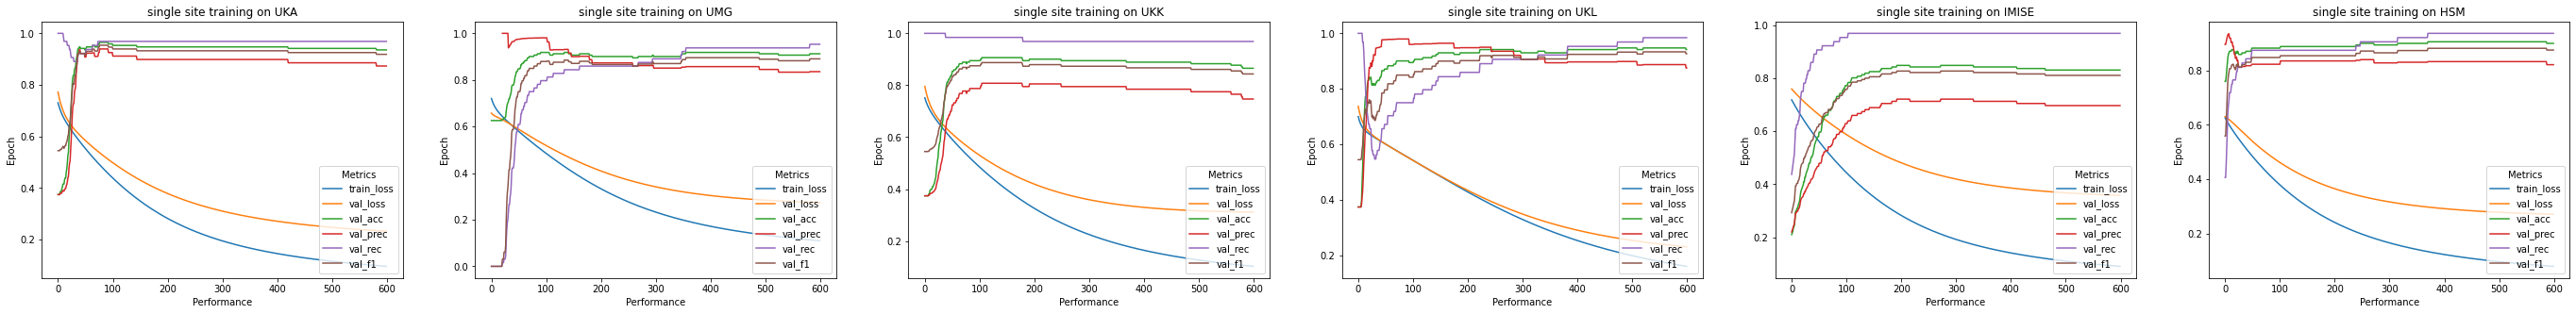

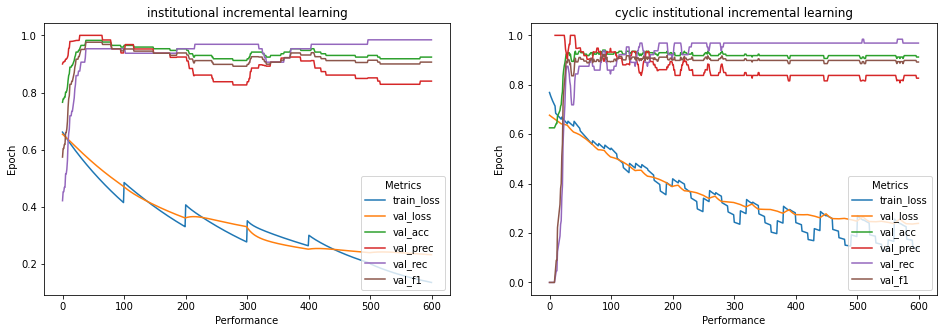

##################################################################################
Start distribution mode: unbalanced_label
##################################################################################
1000 [D loss: 0.731917 , acc: 51.56] [G loss: 0.777893]
2000 [D loss: 0.655410 , acc: 54.30] [G loss: 0.702017]
3000 [D loss: 0.684571 , acc: 52.34] [G loss: 0.741318]
4000 [D loss: 0.740330 , acc: 33.98] [G loss: 0.608486]
5000 [D loss: 0.666397 , acc: 67.97] [G loss: 0.772061]
1000 [D loss: 0.743080 , acc: 26.17] [G loss: 0.673198]
2000 [D loss: 0.683310 , acc: 57.81] [G loss: 0.769357]
3000 [D loss: 0.696941 , acc: 42.19] [G loss: 0.631178]
4000 [D loss: 0.681369 , acc: 58.20] [G loss: 0.682890]
5000 [D loss: 0.676727 , acc: 52.34] [G loss: 0.740500]
1000 [D loss: 0.718931 , acc: 57.03] [G loss: 0.743100]
2000 [D loss: 0.649054 , acc: 64.06] [G loss: 0.709593]
3000 [D loss: 0.673151 , acc: 55.86] [G loss: 0.731059]
4000 [D loss: 0.716489 , acc: 26.56] [G loss: 0.687443]
5000 [D 

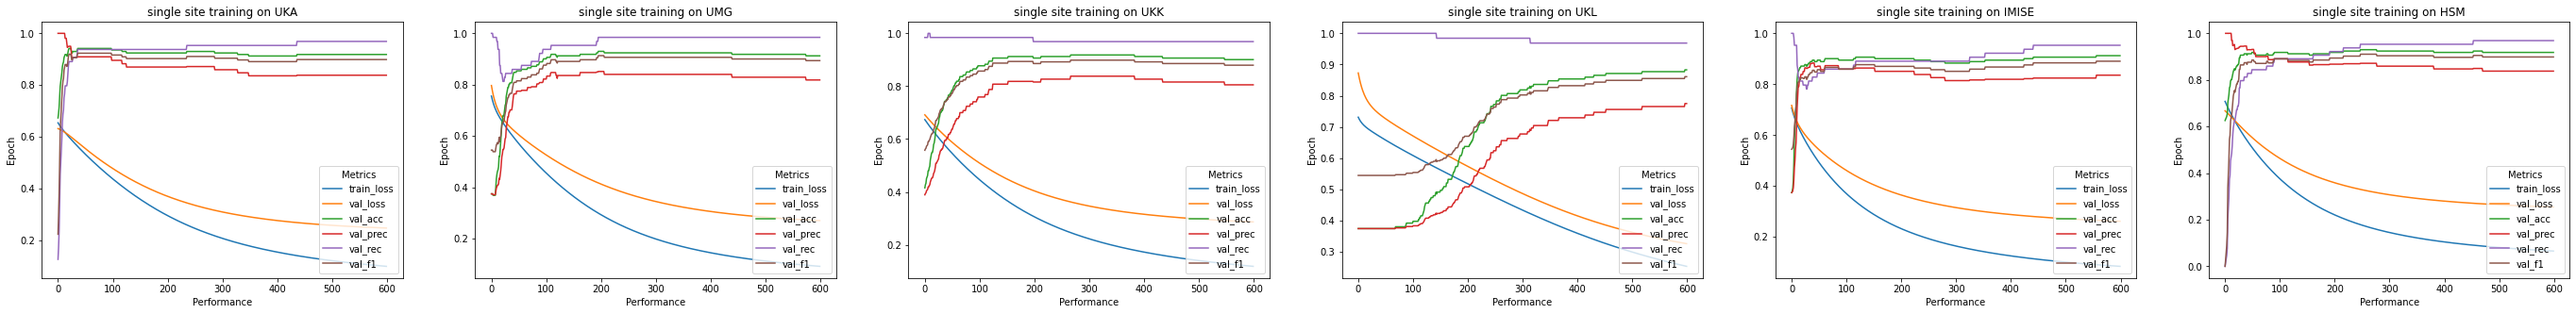

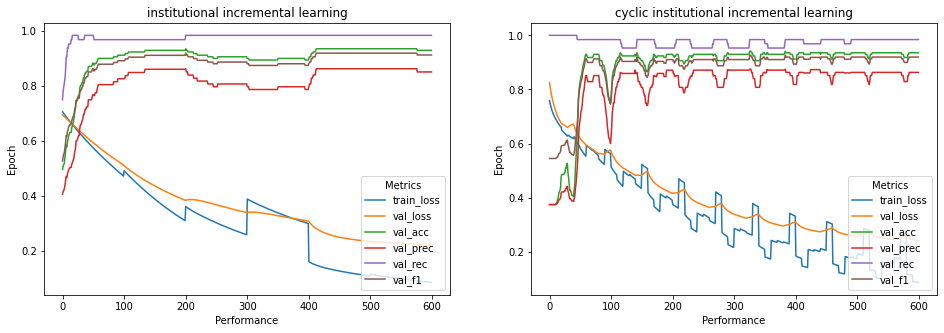

##################################################################################
Start distribution mode: unbalanced_labels_size
##################################################################################
1000 [D loss: 0.685005 , acc: 64.06] [G loss: 0.724455]
2000 [D loss: 0.680319 , acc: 60.16] [G loss: 0.678735]
3000 [D loss: 0.704909 , acc: 49.22] [G loss: 0.659124]
4000 [D loss: 0.671773 , acc: 74.61] [G loss: 0.738617]
5000 [D loss: 0.647993 , acc: 69.53] [G loss: 0.719845]
1000 [D loss: 0.663519 , acc: 75.78] [G loss: 0.776894]
2000 [D loss: 0.679172 , acc: 68.36] [G loss: 0.849501]
3000 [D loss: 0.744191 , acc: 29.69] [G loss: 0.701564]
4000 [D loss: 0.654174 , acc: 53.12] [G loss: 0.749112]
5000 [D loss: 0.787816 , acc: 30.08] [G loss: 0.675386]
1000 [D loss: 0.664784 , acc: 68.75] [G loss: 0.752745]
2000 [D loss: 0.577286 , acc: 83.59] [G loss: 0.935153]
3000 [D loss: 0.751596 , acc: 34.38] [G loss: 0.683708]
4000 [D loss: 0.674719 , acc: 50.39] [G loss: 0.657439]
50

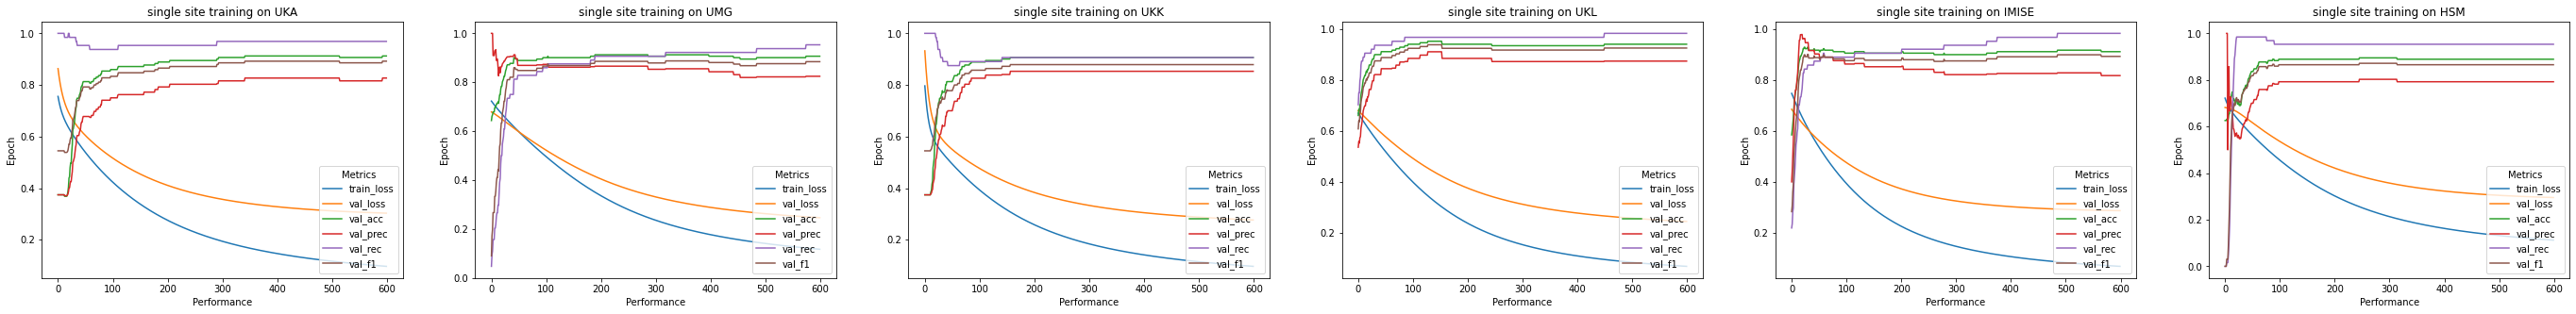

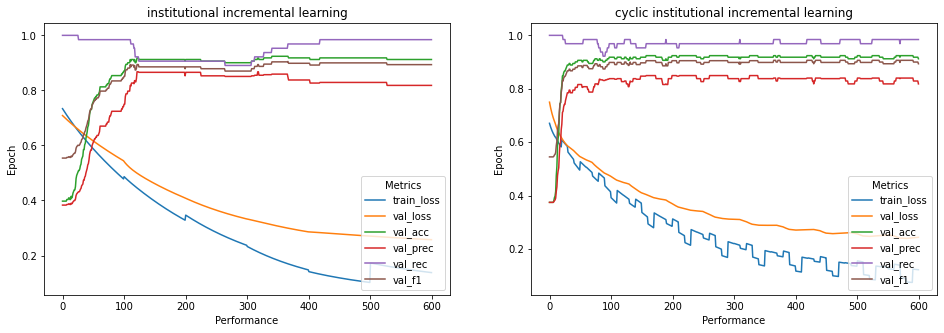

In [2]:
## distribution mode: "input_balanced", "unbalanced_label", "unbalanced_labels_size"
DISTRIBUTION_MODES = ["balanced", "unbalanced_label", "unbalanced_labels_size"]
X_FEATURES = ['radius_mean', 'texture_mean', 'perimeter_mean',
              'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
              'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
              'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
              'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
              'fractal_dimension_se', 'radius_worst', 'texture_worst',
              'perimeter_worst', 'area_worst', 'smoothness_worst',
              'compactness_worst', 'concavity_worst', 'concave points_worst',
              'symmetry_worst', 'fractal_dimension_worst']
## y feature name
Y_FEATURE = 'diagnosis'
BASE_DIR = "/content/drive/MyDrive/DSM-AS"
DATA_DIR = osp.join(BASE_DIR, "input")
RESULT_DIR = osp.join(BASE_DIR, "output")

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.output_layer = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        out = self.output_layer(self.sigmoid(self.hidden_layer(x)))
        return out

def train(X_train, y_train, model, criterion, optimizer):
    inputs = torch.from_numpy(X_train).float()
    targets = torch.from_numpy(y_train).long()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss.item()

def valid(X_test, y_test, model, criterion):
    inputs = torch.from_numpy(X_test).float()
    targets = torch.from_numpy(y_test).long()
    outputs = model(inputs)
    val_loss = criterion(outputs, targets)
    _, predicted = torch.max(outputs, 1)
    cm = confusion_matrix(targets.numpy(), predicted.numpy())
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    with np.errstate(divide='ignore', invalid='ignore'):
        val_acc = (tp + tn) / (tp + fp + fn + tn)
        val_precesion = tp / (tp + fp)
        val_recall = tp / (tp + fn)
        val_f1_score = 2 * tp / (2 * tp + fn + fp)
    return val_loss.item(), val_acc, val_precesion, val_recall, val_f1_score


##################################################################################
## Synthetic Data
##################################################################################
def build_gen(zdim):
    model = Sequential()
    model.add(Dense(31, input_dim=zdim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1 * 31, activation='tanh'))
    return model

def build_cgen(zdim, num_classes=2):
    z = Input(shape=(zdim,))
    lable = Input(shape=(1,), dtype='int32')
    lable_emb = Embedding(num_classes, zdim, input_length=1)(lable)
    lable_emb = Flatten()(lable_emb)
    joined_rep = Multiply()([z, lable_emb])
    gen_v = build_gen(zdim)
    c_img = gen_v(joined_rep)
    return Model([z, lable], c_img)

def build_dis(img_shape, num_classes=2):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(31))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_cdis(img_shape, img_rows=1, img_cols=31, num_classes=2):
    img = Input(shape=(img_cols,))
    lable = Input(shape=(1,), dtype='int32')
    lable_emb = Embedding(num_classes, np.prod((31)), input_length=1)(lable)
    lable_emb = Flatten()(lable_emb)
    # lable_emb=Reshape(img_shape)(lable_emb)
    concate_img = Concatenate(axis=-1)([img, lable_emb])
    dis_v = build_dis((img_cols * 2,))
    classification = dis_v(concate_img)
    return Model([img, lable], classification)

def build_cgan(genrator, discriminator, zdim=100):
    z = Input(shape=(zdim,))
    lable = Input(shape=(1,), dtype='int32')
    f_img = genrator([z, lable])
    classification = discriminator([f_img, lable])
    model = Model([z, lable], classification)
    return model

def show_data(gen, scaler, number_of_rows):
    z = np.random.normal(0, 1, (number_of_rows, 100))
    labels = np.random.randint(2, size=number_of_rows)
    gen_imgs = gen.predict([z, labels])
    gen_imgs = scaler.inverse_transform(gen_imgs)
    for index in range(0, number_of_rows):
        gen_imgs[index] = np.around(gen_imgs[index], 4)
        gen_imgs[index][0] = np.around(gen_imgs[index][0], 0)
    return gen_imgs

def train_synthetic(data, gan_v, gen_v, dis_v, num_classes, iterations, batch_size, interval, number_of_row):
    Xtrainnew = data
    mydata = Xtrainnew.values.tolist()
    ytrain = []
    for j in mydata:
        ytrain.append(j[0])
    Xtrainnew = pd.DataFrame(data=mydata)
    Ytrainnew = np.array(ytrain)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(Xtrainnew)
    Xtrain = scaled
    ytrain = Ytrainnew
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    for iteration in range(iterations):
        ids = np.random.randint(0, Xtrain.shape[0], batch_size)
        imgs = Xtrain[ids]
        labels = ytrain[ids]
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = gen_v.predict([z, labels])
        dloss_real = dis_v.train_on_batch([imgs, labels], real)
        dloss_fake = dis_v.train_on_batch([gen_imgs, labels], fake)
        dloss, accuracy = 0.5 * np.add(dloss_real, dloss_fake)
        z = np.random.normal(0, 1, (batch_size, 100))
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        gloss = gan_v.train_on_batch([z, labels], real)
        if (iteration + 1) % interval == 0:
            # losses.append((dloss, gloss))
            # accuracies.append(100.0 * accuracy)
            # iteration_checks.append(iteration + 1)
            print("%d [D loss: %f , acc: %.2f] [G loss: %f]"%(iteration + 1, dloss, 100.0 * accuracy, gloss))
    return show_data(gen_v, scaler, number_of_row)

def generation_synthetic_data(data, number_of_row):
    img_rows = 1
    img_cols = 31
    img_shape = (img_rows, img_cols)
    zdim = 100
    num_classes = 2
    dis_v = build_cdis(img_shape)
    dis_v.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
    gen_v = build_cgen(zdim)
    dis_v.trainable = False
    gan_v = build_cgan(gen_v, dis_v)
    gan_v.compile(loss='binary_crossentropy', optimizer="adam")
    labels_training = data[Y_FEATURE]
    labels_training = labels_training.map(dict(M=1, B=0))
    features_training = data[X_FEATURES]
    # merge the data to one dataframe again for the training of cGAN
    train_data_synthetic = pd.concat([labels_training, features_training], axis=1, join='inner')
    # print(train_data_synthetic.shape)
    # main method of the training of the cGAN as explained above
    synthetic_data = train_synthetic(data=train_data_synthetic, gan_v=gan_v, gen_v=gen_v, dis_v=dis_v, num_classes=num_classes, iterations=5000, batch_size=128, interval=1000, number_of_row=number_of_row)
    # the random generation for the patient-id, gender and birthday
    # label needs to be transformed to the original values
    label_synthetic = []
    patient_id_synthetic = []
    patient_gender_synthetic = []
    patient_birthday_synthetic = []
    # very simple approach for the missing data generation, note: can be improved
    for row in range(0, len(synthetic_data)):
        synthetic_data_row = synthetic_data[row,]
        if (synthetic_data_row[0] == 1):
            label_synthetic.append("M")
        else:
            label_synthetic.append("B")
        patient_id_synthetic.append(("bbmri" + str(row)))
        p_g = "female"
        p_b = "01.01.2000"
        patient_birthday_synthetic.append(p_b)
        patient_gender_synthetic.append(p_g)
    # use the X_FEATURES of the synthetic data
    synthetic_data = synthetic_data[:, 1:31]
    # write everything in a dataframe for representation
    synthetic_df = pd.DataFrame(np.c_[patient_id_synthetic, patient_gender_synthetic, patient_birthday_synthetic, synthetic_data, label_synthetic],
                      columns=["patient_id", "gender", "birthDate", "radius_mean", "texture_mean",
                                         "perimeter_mean", "area_mean", "smoothness_mean", "compactness_mean",
                                         "concavity_mean", "concave points_mean", "symmetry_mean",
                                         "fractal_dimension_mean",
                                         "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se",
                                         "compactness_se", "concavity_se", "concave points_se", "symmetry_se",
                                         "fractal_dimension_se", "radius_worst", "texture_worst", "perimeter_worst",
                                         "area_worst", "smoothness_worst", "compactness_worst", "concavity_worst",
                                         "concave points_worst", "symmetry_worst", "fractal_dimension_worst", "diagnosis"])
    return synthetic_df

# df_mean_Xs = {}
# df_std_Xs = {}
# df_counts = {}
# df_performances = {}
for distribution_mode in DISTRIBUTION_MODES:
    print("##################################################################################")
    print("Start distribution mode: {}".format(distribution_mode))
    print("##################################################################################")
    experiment_dir = osp.join(RESULT_DIR,"S100",distribution_mode)
    if not os.path.exists(experiment_dir):
        os.makedirs(experiment_dir)
    df_data = pd.read_csv(osp.join(DATA_DIR, "data.csv"))
    df_data = df_data.drop(["Unnamed: 32"], axis=1)
    station_list = ["uka", "umg", "ukk", "ukl", "imise", "hsm"]
    station_dfs = [pd.read_csv(osp.join(DATA_DIR, "{}/{}.csv".format(distribution_mode, station))).rename(columns={"patient_id":"id"}) for station in station_list]
    final_test_df = pd.read_csv(osp.join(DATA_DIR, "{}/final_test.csv".format(distribution_mode))).rename(columns={"patient_id":"id"})
    for idx in range(len(station_list)):
        station_dfs[idx]["id"] = station_dfs[idx]["id"].map(lambda x: int(x[6:]))
        station_dfs[idx] = pd.merge(df_data, station_dfs[idx], on='id', how='right')
    final_test_df["id"] = final_test_df["id"].map(lambda x: int(x[6:]))
    final_test_df = pd.merge(df_data, final_test_df, on='id', how='right')
    # df_count = []
    # for idx in range(len(station_dfs)):
    #     B, M = station_dfs[idx]["diagnosis"].value_counts()
    #     df_count.append([len(station_dfs[idx]), B, M])
    # B, M = final_test_df["diagnosis"].value_counts()
    # df_count.append([len(final_test_df), B, M])
    # df_count = pd.DataFrame(df_count, columns=["counts", "B", "M"])
    # df_count["station"] = pd.Series(station_list+["final test"])
    # df_mean_X = []
    # df_std_X = []
    # for idx in range(len(station_list)):
    #     df_mean_X.append(np.mean(station_dfs[idx][X_FEATURES], axis=0).to_numpy())
    #     df_std_X.append(np.std(station_dfs[idx][X_FEATURES], axis=0).to_numpy())
    # df_mean_X.append(np.mean(final_test_df[X_FEATURES], axis=0).to_numpy())
    # df_std_X.append(np.std(final_test_df[X_FEATURES], axis=0).to_numpy())
    # df_mean_X = pd.DataFrame(df_mean_X, columns=X_FEATURES)
    # df_std_X = pd.DataFrame(df_std_X, columns=X_FEATURES)
    # df_mean_X["station"] = pd.Series(station_list+["final test"])
    # df_std_X["station"] = pd.Series(station_list+["final test"])
    # df_counts[distribution_mode] = df_count
    # df_mean_Xs[distribution_mode] = df_mean_X
    # df_std_Xs[distribution_mode] = df_std_X

    test_scaler = StandardScaler()
    X_test = final_test_df[X_FEATURES]
    y_test = final_test_df[Y_FEATURE]
    X_test = test_scaler.fit_transform(X_test)
    y_test.replace(to_replace=dict(M=1, B=0), inplace=True)
    y_test = y_test.to_numpy()
    
    synthetic_dfs = [generation_synthetic_data(station_dfs[idx], number_of_row=1000) for idx in range(len(station_dfs))]

    ##################################################################################
    ## Single site training
    ##################################################################################
    fig, axs = plt.subplots(1, 6,figsize=(48, 5))
    input_dim = 30
    hidden_dim = 64
    num_classes = 2
    learning_rate = 0.01
    weight_decay = 0.0005
    num_epochs = 600
    criterion = nn.CrossEntropyLoss()
    for idx in range(len(station_list)):
        scaler = StandardScaler()
        df_X = synthetic_dfs[idx][X_FEATURES]
        df_Y = synthetic_dfs[idx][Y_FEATURE]
        df_X = scaler.fit_transform(df_X)
        df_Y.replace(to_replace=dict(M=1, B=0), inplace=True)
        df_Y = df_Y.to_numpy()
        model = LogisticRegression(input_dim, hidden_dim, num_classes)
        optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        losses = []
        val_losses = []
        val_accs = []
        val_precs = []
        val_recs = []
        val_f1s = []
        results = []
        for epoch in range(num_epochs):
            perm = np.arange(df_X.shape[0])
            np.random.shuffle(perm)
            X_train = df_X[perm]
            y_train = df_Y[perm]
            loss = train(X_train, y_train, model, criterion, optim)
            val_loss, val_acc, val_precesion, val_recall, val_f1_score = valid(X_test, y_test, model, criterion)
            losses.append(loss)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_precs.append(val_precesion)
            val_recs.append(val_recall)
            val_f1s.append(val_f1_score)
            results.append([epoch, loss, val_loss, val_acc, val_precesion, val_recall, val_f1_score])
        axs[idx].plot(losses, label="train_loss")
        axs[idx].plot(val_losses, label="val_loss")
        axs[idx].plot(val_accs, label="val_acc")
        axs[idx].plot(val_precs, label="val_prec")
        axs[idx].plot(val_recs, label="val_rec")
        axs[idx].plot(val_f1s, label="val_f1")
        axs[idx].legend(title="Metrics", loc="lower right")
        axs[idx].title.set_text("single site training on {}".format(station_list[idx].upper())),
        axs[idx].set_ylabel("Epoch")
        axs[idx].set_xlabel("Performance")
        print("single site training on {}".format(station_list[idx].upper()))
        print("acc {:.2f} precision {:.2f} recall {:.2f} f1 {:.2f}".format(val_accs[-1]*100, val_precs[-1]*100, val_recs[-1]*100, val_f1s[-1]*100))
        # print("acc {:.2f}, precision {:.2f}, recall {:.2f}, f1 {:.2f}".format(val_accs[-1]*100, val_precs[-1]*100, val_recs[-1]*100, val_f1s[-1]*100))
        results = pd.DataFrame(np.array(results), columns=["epoch", "loss", "val_loss", "val_acc", "val_prec", "val_rec", "val_f1"])
        results.to_csv(osp.join(experiment_dir, f"sst_{station_list[idx]}_result.csv"),index=False)  
    
    fig, axs = plt.subplots(1, 2, figsize=(16,  5))
    ##################################################################################
    ## Institutional Incremental Learning
    ##################################################################################
    input_dim = 30
    hidden_dim = 64
    num_classes = 2
    learning_rate = 0.01
    weight_decay = 0.0005
    num_epochs = 100
    criterion = nn.CrossEntropyLoss()
    model = LogisticRegression(input_dim, hidden_dim, num_classes)
    losses = []
    val_losses = []
    val_accs = []
    val_precs = []
    val_recs = []
    val_f1s = []
    results = []
    for idx in range(len(station_list)):
        optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scaler = StandardScaler()
        df_X = synthetic_dfs[idx][X_FEATURES]
        df_Y = synthetic_dfs[idx][Y_FEATURE]
        df_X = scaler.fit_transform(df_X)
        # df_Y.replace(to_replace=dict(M=1, B=0), inplace=True)
        df_Y = df_Y.to_numpy()
        for epoch in range(num_epochs):
            perm = np.arange(df_X.shape[0])
            np.random.shuffle(perm)
            X_train = df_X[perm]
            y_train = df_Y[perm]
            loss = train(X_train, y_train, model, criterion, optim)
            val_loss, val_acc, val_precesion, val_recall, val_f1_score = valid(X_test, y_test, model, criterion)
            losses.append(loss)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_precs.append(val_precesion)
            val_recs.append(val_recall)
            val_f1s.append(val_f1_score)
            results.append([epoch, loss, val_loss, val_acc, val_precesion, val_recall, val_f1_score])
    axs[0].plot(losses, label="train_loss")
    axs[0].plot(val_losses, label="val_loss")
    axs[0].plot(val_accs, label="val_acc")
    axs[0].plot(val_precs, label="val_prec") 
    axs[0].plot(val_recs, label="val_rec")
    axs[0].plot(val_f1s, label="val_f1")
    axs[0].legend(title="Metrics", loc="lower right")
    axs[0].title.set_text("institutional incremental learning"),
    axs[0].set_ylabel("Epoch")
    axs[0].set_xlabel("Performance")
    print("institutional incremental learning")
    print("acc {:.2f} precision {:.2f} recall {:.2f} f1 {:.2f}".format(val_accs[-1]*100, val_precs[-1]*100, val_recs[-1]*100, val_f1s[-1]*100))
    # print("acc {:.2f}, precision {:.2f}, recall {:.2f}, f1 {:.2f}".format(val_accs[-1]*100, val_precs[-1]*100, val_recs[-1]*100, val_f1s[-1]*100))
    results = pd.DataFrame(np.array(results), columns=["epoch", "loss", "val_loss", "val_acc", "val_prec", "val_rec", "val_f1"])
    results.to_csv(osp.join(experiment_dir, "iil_result.csv"),index=False)   
    
    ##################################################################################
    ## Cyclic Institutional Incremental Learning
    ##################################################################################
    input_dim = 30
    hidden_dim = 64
    num_classes = 2
    learning_rate = 0.01
    weight_decay = 0.0005
    num_cycles = 10
    num_epochs = 10
    criterion = nn.CrossEntropyLoss()
    model = LogisticRegression(input_dim, hidden_dim, num_classes)

    losses = []
    val_losses = []
    val_accs = []
    val_precs = []
    val_recs = []
    val_f1s = []
    results = []
    for cycle in range(num_cycles):
        for idx in range(len(station_list)):
            optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            scaler = StandardScaler()
            df_X = synthetic_dfs[idx][X_FEATURES]
            df_Y = synthetic_dfs[idx][Y_FEATURE]
            df_X = scaler.fit_transform(df_X)
            # df_Y.replace(to_replace=dict(M=1, B=0), inplace=True)
            df_Y = df_Y.to_numpy()
            for epoch in range(num_epochs):
                perm = np.arange(df_X.shape[0])
                np.random.shuffle(perm)
                X_train = df_X[perm]
                y_train = df_Y[perm]
                loss = train(X_train, y_train, model, criterion, optim)
                val_loss, val_acc, val_precesion, val_recall, val_f1_score = valid(X_test, y_test, model, criterion)
                losses.append(loss)
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_precs.append(val_precesion)
                val_recs.append(val_recall)
                val_f1s.append(val_f1_score)
                results.append([epoch, loss, val_loss, val_acc, val_precesion, val_recall, val_f1_score])

    axs[1].plot(losses, label="train_loss")
    axs[1].plot(val_losses, label="val_loss")
    axs[1].plot(val_accs, label="val_acc")
    axs[1].plot(val_precs, label="val_prec") 
    axs[1].plot(val_recs, label="val_rec")
    axs[1].plot(val_f1s, label="val_f1")
    axs[1].legend(title="Metrics", loc="lower right")
    axs[1].title.set_text("cyclic institutional incremental learning"),
    axs[1].set_ylabel("Epoch")
    axs[1].set_xlabel("Performance")
    print("cyclic institutional incremental learning")
    print("acc {:.2f} precision {:.2f} recall {:.2f} f1 {:.2f}".format(val_accs[-1]*100, val_precs[-1]*100, val_recs[-1]*100, val_f1s[-1]*100))
    # print("acc {:.2f}, precision {:.2f}, recall {:.2f}, f1 {:.2f}".format(val_accs[-1]*100, val_precs[-1]*100, val_recs[-1]*100, val_f1s[-1]*100))
    results = pd.DataFrame(np.array(results), columns=["epoch", "loss", "val_loss", "val_acc", "val_prec", "val_rec", "val_f1"])
    results.to_csv(osp.join(experiment_dir, "ciil_result.csv"),index=False) 
    plt.show()